<a href="https://colab.research.google.com/github/natanrajch/DiploDatos/blob/main/MELI/train_data_joined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gzip
import pandas as pd
import urllib
import tarfile
import urllib.request
import numpy as np
import random
import json
import bisect
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
url_item_data = "https://meli-data-challenge.s3.amazonaws.com/2020/item_data.jl.gz"
url_train_data = "https://meli-data-challenge.s3.amazonaws.com/2020/train_dataset.jl.gz"
url_test_data = "https://meli-data-challenge.s3.amazonaws.com/2020/test_dataset.jl.gz"

In [3]:
# PARA TRABAJAR CON UNA SAMPLE DEL TRAIN DATA SET:
# sample = 150000
# def binary_search(items, key, lo=0):
#     idx = bisect.bisect_left(items, key, lo)
#     if items[idx] != key:
#          return -1

#     return idx
# sample_list = random.sample(list(range(420000)),sample)
# sample_list.sort()
# ind = 0
# train_data = []
# with urllib.request.urlopen(url_train_data) as handle:
#   gz = gzip.GzipFile(fileobj=handle)
#   for i, line in enumerate(gz):
#     binary = binary_search(sample_list,i,ind)
#     if binary != -1:
#       train_data.append(json.loads(line.strip().decode('utf-8')))
#       ind = binary
train_data = []
with urllib.request.urlopen(url_train_data) as handle:
  gz = gzip.GzipFile(fileobj=handle)
  for i, line in enumerate(gz):
    train_data.append(json.loads(line.strip().decode('utf-8')))





In [4]:
df = pd.DataFrame(train_data)
del train_data
del gz

In [5]:
df

,user_history,item_bought
0,"[{'event_info': 1786148, 'event_timestamp': '2...",1748830
1,"[{'event_info': 643652, 'event_timestamp': '20...",228737
2,"[{'event_info': 248595, 'event_timestamp': '20...",1909110
3,"[{'event_info': 'RADIOBOSS', 'event_timestamp'...",1197370
4,"[{'event_info': 'AMAZFIT BIP', 'event_timestam...",2049207
...,...,...
413158,"[{'event_info': 'PC GAMER', 'event_timestamp':...",459697
413159,"[{'event_info': 289961, 'event_timestamp': '20...",1845503
413160,"[{'event_info': 'ALUGUEL BOB CAT', 'event_time...",2022477
413161,"[{'event_info': 'XAOMI', 'event_timestamp': '2...",1111021


In [6]:
len(df.item_bought.unique())

64928

##El item comprado fue visto con anterioridad?
Sólo en el 29,38% de los casos

In [7]:
df['bought_was_viewed'] = df.apply(lambda row: row['item_bought'] in [history['event_info'] for history in row['user_history']], axis=1)
df.bought_was_viewed.value_counts(normalize=True)

False    0.706116
True     0.293884
Name: bought_was_viewed, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'El item comprado fue visto con anterioridad? \n Sólo en el 29.38% de los casos')

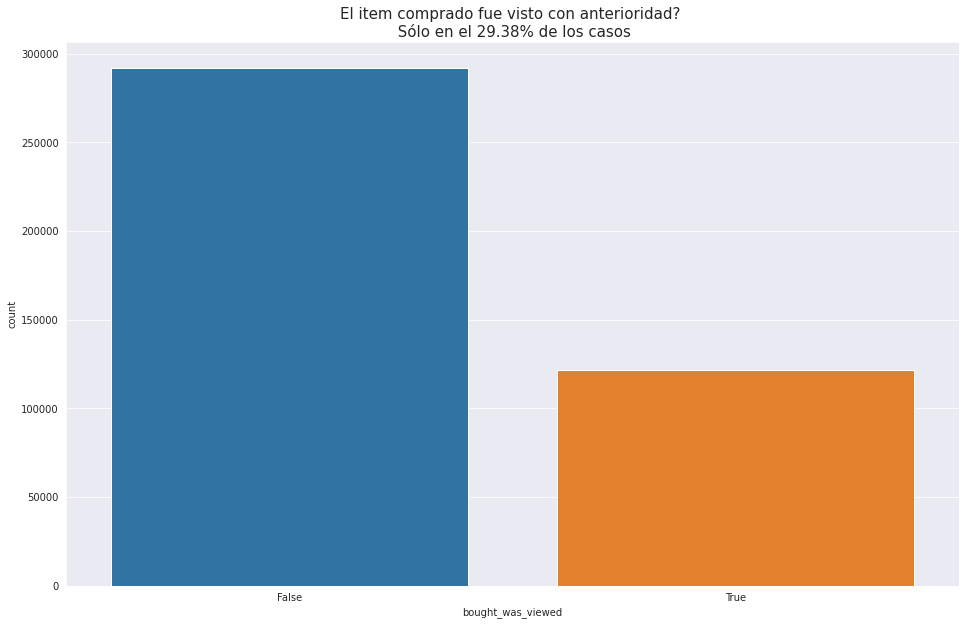

In [80]:
fig, axes = plt.subplots(1, figsize=(16,10))
sns.countplot(df['bought_was_viewed'], ax=axes)
axes.set_title('El item comprado fue visto con anterioridad? \n Sólo en el 29.38% de los casos', fontdict={'fontsize':15})

## Cuántas Views y cuántas Search por compra?

In [8]:
def count_event_type(list_of_events, type_of_event):
  count = 0
  for event in list_of_events:
    if event['event_type'] == type_of_event:
      count += 1
  return count

df['view_count'] = df.apply(lambda row: count_event_type(row['user_history'],'view'), axis = 1)
df['search_count'] = df.apply(lambda row: count_event_type(row['user_history'],'search'), axis = 1)
df['event_count'] = df.view_count + df.search_count

In [9]:
def count_bought_views(list_of_events, item_bought):
  count = 0
  for event in list_of_events:
    if event['event_type'] == 'view':
      if event['event_info'] == item_bought:
        count += 1
  return count

df['bought_view_count'] = df.apply(lambda row: count_bought_views(row['user_history'],row['item_bought']), axis = 1)

In [10]:
df.describe()

,item_bought,view_count,search_count,event_count,bought_view_count
count,4.131630e+05,413163.000000,413163.000000,413163.000000,413163.000000
mean,1.058022e+06,14.352730,14.689478,29.042209,1.223357
std,6.027066e+05,19.293081,20.457799,36.278935,2.914499
min,3.300000e+01,0.000000,0.000000,1.000000,0.000000
25%,5.482550e+05,2.000000,1.000000,5.000000,0.000000
50%,1.057231e+06,7.000000,7.000000,16.000000,0.000000
75%,1.584960e+06,18.000000,19.000000,39.000000,1.000000
max,2.102239e+06,342.000000,284.000000,566.000000,75.000000


Text(0.5, 1.0, 'Relación cantidad de searchs y views')

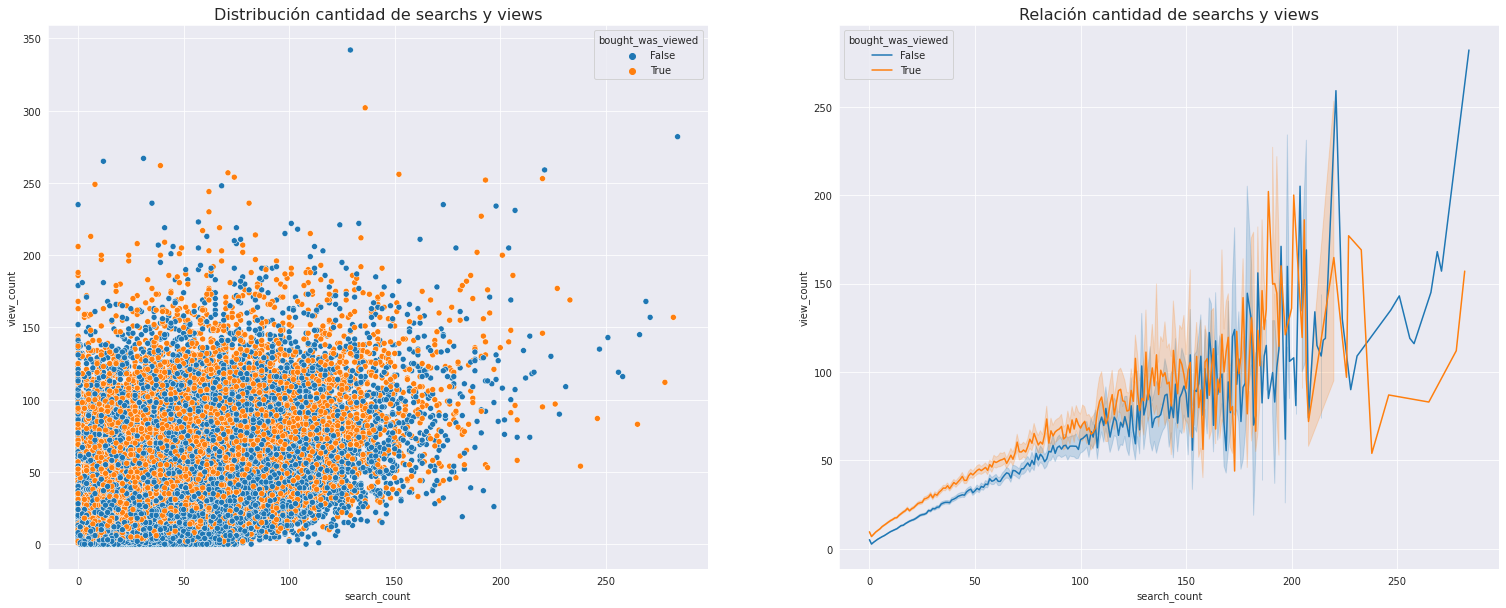

In [82]:
fig, axes = plt.subplots(1,2, figsize=(26,10))
# for ax in axes:
#   ax.set_xlim(0,30)
# sns.countplot(df.view_count, ax=axes[0], order=list(range(30)))
# sns.countplot(df.search_count, ax=axes[1], order=list(range(30)))
sns.scatterplot(x=df.search_count, y=df.view_count, ax=axes[0], 
                hue=df.bought_was_viewed)
sns.lineplot(x=df.search_count, y=df.view_count, ax=axes[1], 
                hue=df.bought_was_viewed)
axes[0].set_title('Distribución cantidad de searchs y views', fontdict={'fontsize': 16})
axes[1].set_title('Relación cantidad de searchs y views', fontdict={'fontsize': 16})

Text(0.5, 1.0, 'Zoom del descenso entre search = 0 y search=1')

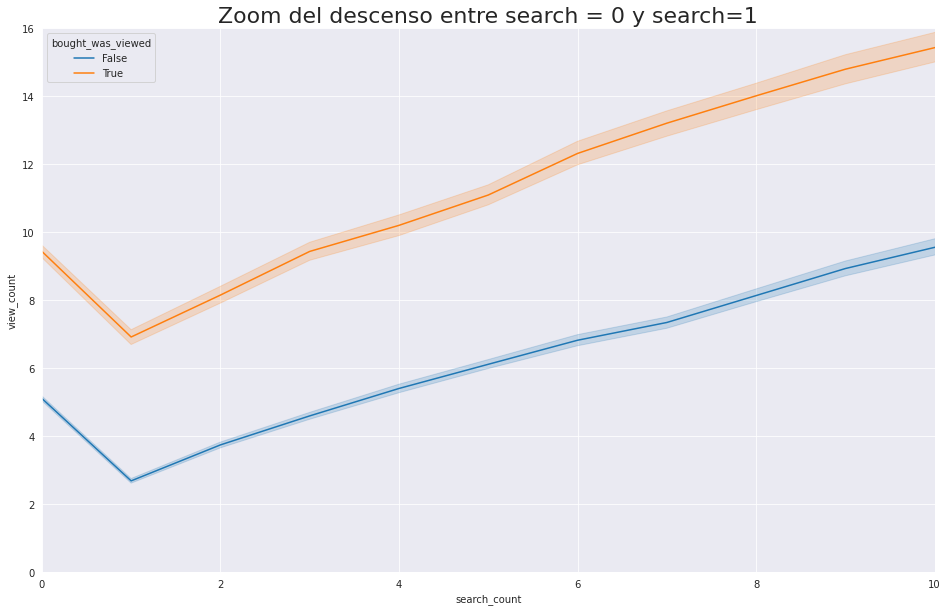

In [92]:
fig, ax = plt.subplots(1, figsize=(16,10))
# for ax in axes:
#   ax.set_xlim(0,30)
# sns.countplot(df.view_count, ax=axes[0], order=list(range(30)))
# sns.countplot(df.search_count, ax=axes[1], order=list(range(30)))
# sns.scatterplot(x=df.search_count, y=df.view_count, ax=axes[0], 
#                 hue=df.bought_was_viewed)
sns.lineplot(x=df[df.event_count < 100].search_count, y=df[df.event_count < 100].view_count, ax=ax, 
                hue=df[df.event_count < 100].bought_was_viewed)

ax.set_xlim(0,10)
ax.set_ylim(0,16)
ax.set_title('Zoom del descenso entre search = 0 y search=1', fontdict={'fontsize': 22})
# axes[0].set_title('Distribución cantidad de searchs y views', fontdict={'fontsize': 16})
# axes[1].set_title('Relación cantidad de searchs y views', fontdict={'fontsize': 16})

Por qué se ve un cambio tan marcado entre los que realizan 0 searches y el resto??

(0.0, 200.0)

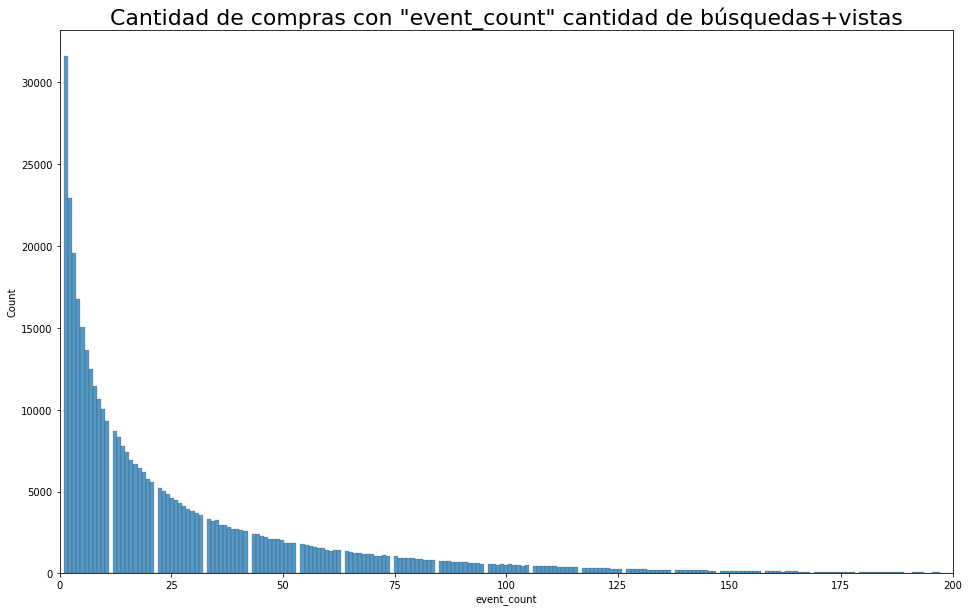

In [12]:
fig, axes = plt.subplots(1, figsize=(16,10))
sns.histplot(x=df.event_count, ax=axes)
axes.set_title('Cantidad de compras con "event_count" cantidad de búsquedas+vistas', fontdict={'fontsize': 22})
axes.set_xlim(0,200)

(0.0, 100.0)

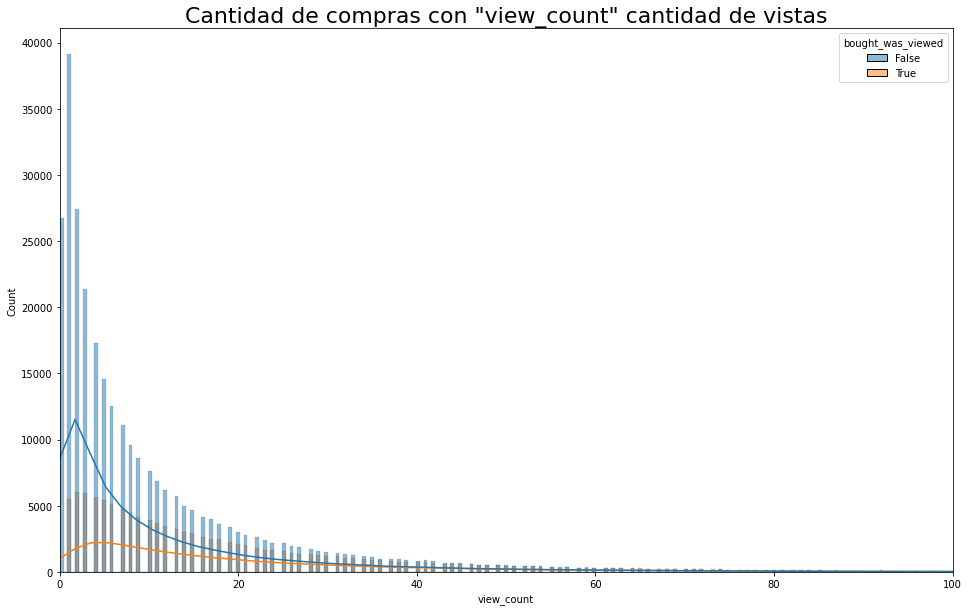

In [13]:
fig, axes = plt.subplots(1, figsize=(16,10))
sns.histplot(x=df.view_count, ax=axes, kde=True, hue=df.bought_was_viewed
             )
axes.set_title('Cantidad de compras con "view_count" cantidad de vistas', fontdict={'fontsize': 22})
axes.set_xlim(0,100)

(-1.0, 20.0)

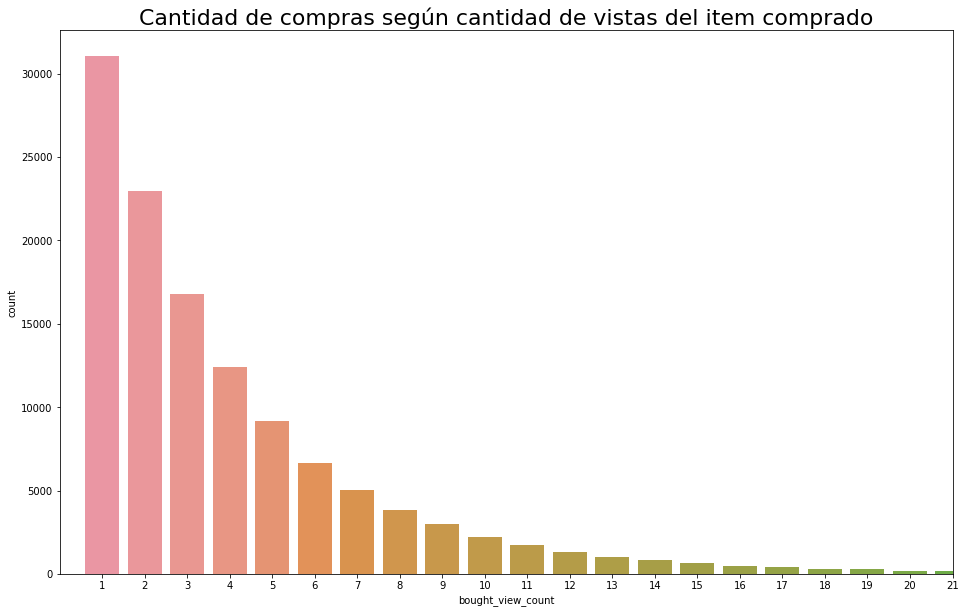

In [14]:
fig, axes = plt.subplots(1, figsize=(16,10))
sns.countplot(x=df[df.bought_was_viewed].bought_view_count, ax=axes
             )
axes.set_title('Cantidad de compras según cantidad de vistas del item comprado \n (sólo para casos con al menos 1 vista)', fontdict={'fontsize': 22})
axes.set_xlim(-1,20)

Text(0.5, 1.0, 'La relación entre vistas totales y vistas del ítem a comprar \n tiene un límite cercano a 10')

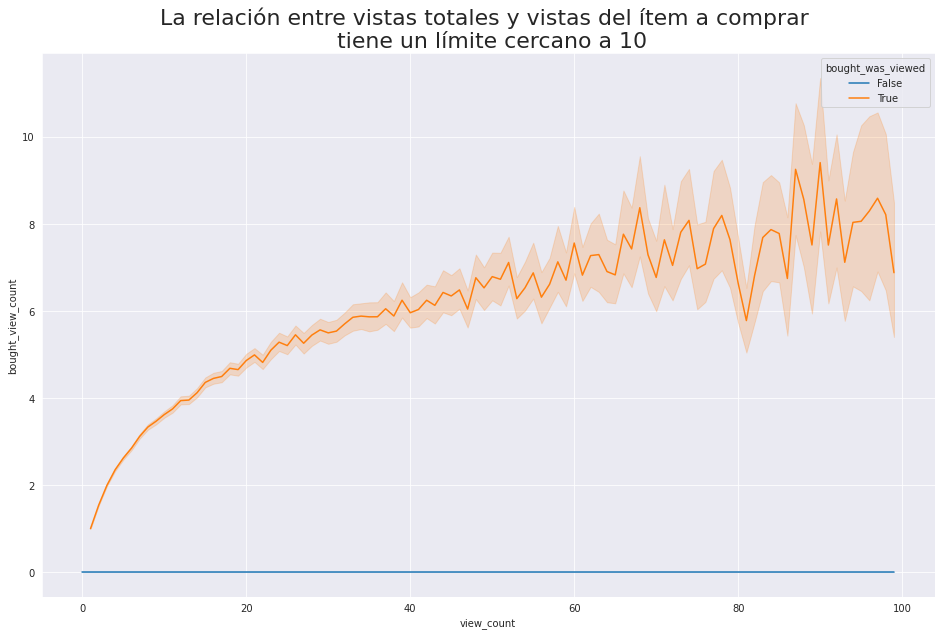

In [97]:
# sns.jointplot(data=df[df.view_count < 40], x='view_count', y='bought_view_count', 
#                 hue='bought_was_viewed', height=10, alpha=0.01, xlim=(0,200), ylim=(0,30))
fig, axes = plt.subplots(1, figsize=(16,10))
sns.lineplot(data=df[df.view_count < 100], x='view_count', y='bought_view_count', 
                hue='bought_was_viewed', ax=axes)
axes.set_title('La relación entre vistas totales y vistas del ítem a comprar \n tiene un límite cercano a 10', fontdict={'fontsize': 22})

# sns.jointplot(x=df.view_count, y=df.bought_view_count, 
#                 hue=df.bought_was_viewed, height=10, xlim=(-1,30), ylim=(-1,30), alpha=0.1)



Esto nos marca que conforme más activo es una persona en MELI, más difícil es predecir qué va a comprar

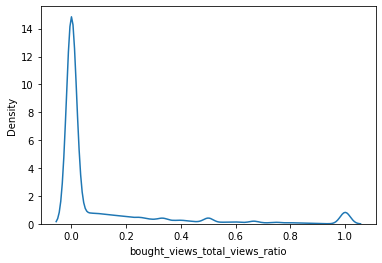

In [16]:
df['bought_views_total_views_ratio'] = df.bought_view_count / df.view_count
sns.kdeplot(df.bought_views_total_views_ratio)

In [17]:
len(df), len(df[(df.search_count < 150) & (df.view_count < 150)]), len(df[(df.search_count < 150) & (df.view_count < 150)])/len(df)

(413163, 412312, 0.9979402802283844)

Text(0.5, 1.0, 'Distribución de la cantidad de Vistas antes de una compra')

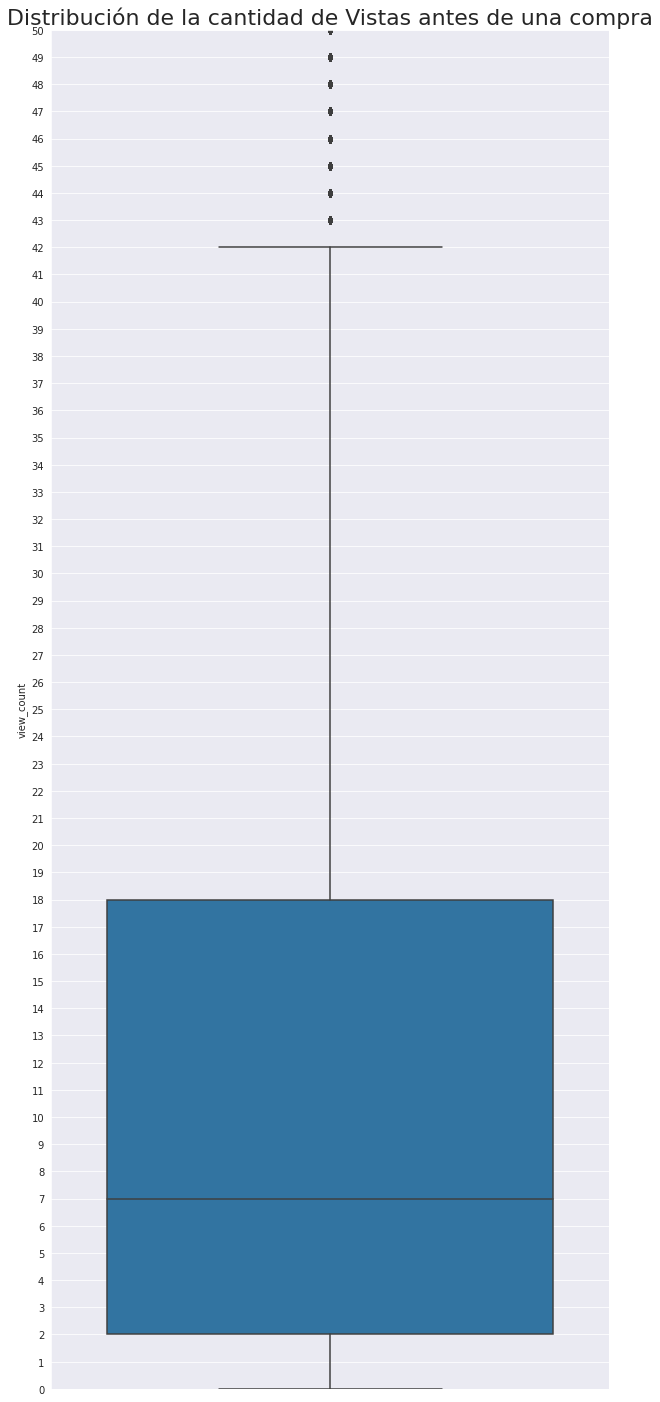

In [18]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10,25))

sns.boxplot(y =df.view_count , ax=ax)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_ylim(0,50)
ax.set_title('Distribución de la cantidad de Vistas antes de una compra', fontdict={'fontsize': 22})


Text(0.5, 1.0, 'Distribución de la cantidad de Vistas del item a comprar, antes de una compra')

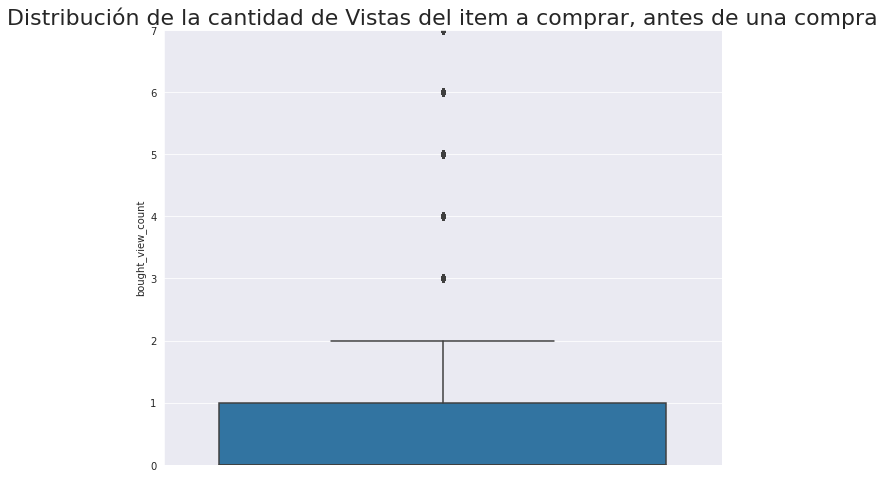

In [19]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10,8))

sns.boxplot(y =df.bought_view_count , ax=ax)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_ylim(0,7)
ax.set_title('Distribución de la cantidad de Vistas del item a comprar, antes de una compra', fontdict={'fontsize': 22})

Text(0.5, 1.0, 'Distribución del ratio Vistas del item a comprar/total visto')

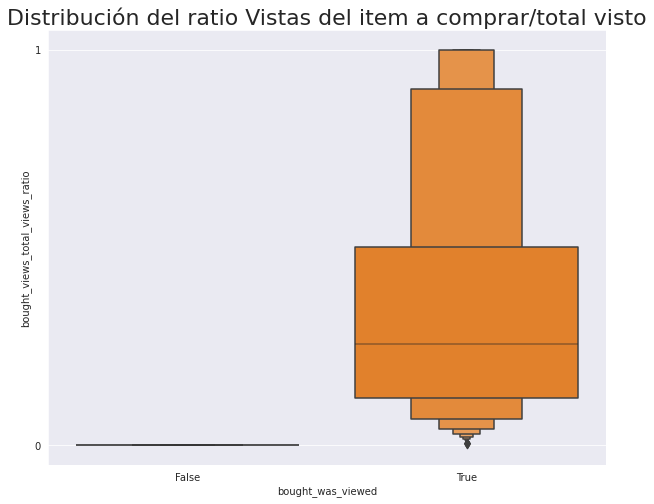

In [20]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10,8))

sns.boxenplot(y =df.bought_views_total_views_ratio, x=df.bought_was_viewed, ax=ax)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.set_ylim(0,1)
ax.set_title('Distribución del ratio Vistas del item a comprar/total visto', fontdict={'fontsize': 22})

Text(0.5, 1.0, 'Distribución de la cantidad de Vistas del item a comprar, antes de una compra')

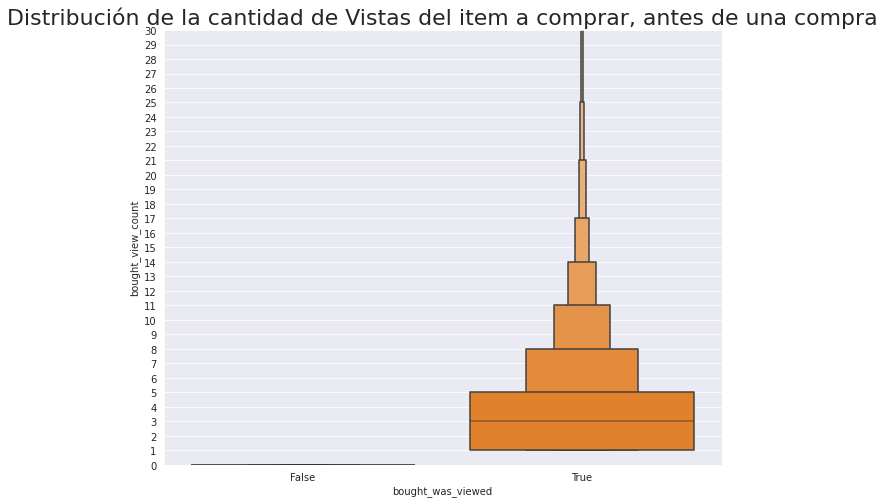

In [21]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10,8))

sns.boxenplot(y =df.bought_view_count , x=df.bought_was_viewed, ax=ax)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_ylim(0,30)
ax.set_title('Distribución de la cantidad de Vistas del item a comprar, antes de una compra', fontdict={'fontsize': 22})

## Se hace el Merge con los datos del item_data

In [22]:
item_data = []
with urllib.request.urlopen(url_item_data) as handle:
  gz = gzip.GzipFile(fileobj=handle)
  for i, line in enumerate(gz):
    item_data.append(json.loads(line.strip().decode('utf-8')))

itemdf = pd.DataFrame(item_data)
del item_data
del gz

In [23]:
itemdf.head(2)

,item_id,title,domain_id,product_id,price,category_id,condition
0,111260,Casa Sola En Venta Con Gran Patio Solo Pago De...,MLM-INDIVIDUAL_HOUSES_FOR_SALE,None,1150000.00,MLM170527,new
1,871377,Resident Evil Origins Collection Nintendo Swit...,MLM-VIDEO_GAMES,15270800,1392.83,MLM151595,new
2,490232,Falda De Imitación Piel Negra,MLM-SKIRTS,None,350.00,MLM7697,new
3,1150706,Powercolor Red Devil Radeon Rx 580 8gb Gddr5,MLM-GRAPHICS_CARDS,None,3200.00,MLM9761,used
4,934912,Laptop Hp Nx6320 Core Duo Con Puerto Db9 Windo...,MLM-NOTEBOOKS,None,1599.00,MLM1652,used


In [24]:
df.item_bought.isin(itemdf.item_id).value_counts()

True    413163
Name: item_bought, dtype: int64

In [25]:
df_joined = pd.merge(df, itemdf, left_on='item_bought', right_on='item_id', how='left')
df_joined.head(1)

,user_history,item_bought,bought_was_viewed,view_count,search_count,event_count,bought_view_count,bought_views_total_views_ratio,item_id,title,domain_id,product_id,price,category_id,condition
0,"[{'event_info': 1786148, 'event_timestamp': '2...",1748830,False,18,1,19,0,0.0,1748830,Relógio Medidor Inteligente Pulso Freqüência C...,MLB-SMARTWATCHES,None,90.00,MLB135384,new


## Análisis de la condición de artículos (usados vs nuevos) comprados en el dataset

In [26]:
df_joined.groupby('condition').describe()

item_bought                ...    item_id           
                    count          mean  ...        75%        max
condition                                ...                      
new              412637.0  1.057991e+06  ...  1585033.0  2102239.0
not_specified       115.0  1.056598e+06  ...  1333797.0  2049655.0
used                411.0  1.089228e+06  ...  1497812.0  2094313.0

[3 rows x 56 columns]

Hay muy poco ítems no nuevos en nuestro dataset

## Análisis de la procedencia de la compra: BRASIL (MLB) o MEXICO (MLM) en el dataset

In [27]:
df_joined.groupby(df_joined.domain_id.str[:4])[['view_count','search_count','event_count']].describe()

view_count                             ... event_count                   
               count       mean        std  min  ...         25%   50%   75%    max
domain_id                                        ...                               
MLB-        354907.0  14.269335  19.263570  0.0  ...         5.0  15.0  38.0  566.0
MLM-         58256.0  14.860787  19.464348  0.0  ...         6.0  16.0  40.0  438.0

[2 rows x 24 columns]

Menos del 15% de las compras se realizaron en México

##Comparación: Conteo de categorías en tabla train_data y luego, conteo de categorías en tabla item_data
Sin diferenciar por pais



In [28]:
df_joined.groupby(df_joined.domain_id.str[4:]).count().sort_values(by='user_history', ascending=False).head(15)

,user_history,item_bought,bought_was_viewed,view_count,search_count,event_count,bought_view_count,bought_views_total_views_ratio,item_id,title,domain_id,product_id,price,category_id,condition
domain_id,,,,,,,,,,,,,,,
CELLPHONES,27017,27017,27017,27017,27017,27017,27017,25868,27017,27017,27017,23839,27017,27017,27017
SNEAKERS,15016,15016,15016,15016,15016,15016,15016,14254,15016,15016,15016,1327,15016,15016,15016
HEADPHONES,13656,13656,13656,13656,13656,13656,13656,12904,13656,13656,13656,6924,13656,13656,13656
SUPPLEMENTS,10000,10000,10000,10000,10000,10000,10000,9214,10000,10000,10000,3875,10000,10000,10000
SMARTWATCHES,9606,9606,9606,9606,9606,9606,9606,9104,9606,9606,9606,4527,9606,9606,9606
VIDEO_GAMES,5289,5289,5289,5289,5289,5289,5289,4858,5289,5289,5289,1927,5289,5289,5289
DOLLS,4956,4956,4956,4956,4956,4956,4956,4700,4956,4956,4956,241,4956,4956,4956
BOOTS_AND_BOOTIES,4469,4469,4469,4469,4469,4469,4469,4181,4469,4469,4469,0,4469,4469,4469
STREAMING_MEDIA_DEVICES,4415,4415,4415,4415,4415,4415,4415,4147,4415,4415,4415,1988,4415,4415,4415


###Conteo de categorías en tabla item_data:
Sin diferenciar por pais

In [29]:
itemdf.groupby(itemdf.domain_id.str[4:]).count().sort_values(by='title', ascending=False).head(15)

,item_id,title,domain_id,product_id,price,category_id,condition
domain_id,,,,,,,
CARS_AND_VANS,55585,55585,55585,44775,55585,55585,55585
CELLPHONES,46425,46425,46425,40234,46425,46425,46425
SNEAKERS,42460,42460,42460,1045,42460,42460,42460
VEHICLE_ACCESSORIES,34011,34011,34011,32,34011,34011,34011
T_SHIRTS,28130,28130,28130,6,28130,28130,28130
DRESSES,24981,24981,24981,12,24981,24981,24981
SUPPLEMENTS,24111,24111,24111,8017,24111,24111,24111
VEHICLE_PARTS,21739,21739,21739,4,21739,21739,21739
CELLPHONE_COVERS,18652,18652,18652,32,18652,18652,18652


### DOMAINS LIMPIADOS DEL DATASET TRAIN_DATA:

In [30]:
train_domains_list = df_joined.groupby(df_joined.domain_id.str[4:]).count().sort_values(by='user_history', ascending=False).index.tolist()
item_domains_list = itemdf[['domain_id','title']].groupby(itemdf.domain_id.str[4:]).count().sort_values(by='title', ascending=False).index
itemdf[['domain_id','title']].groupby(itemdf.domain_id.str[4:]).count().sort_values(by='title', ascending=False)[~item_domains_list.isin(train_domains_list)].head(20)

,domain_id,title
domain_id,,
CARS_AND_VANS,55585,55585
MOTORCYCLES,12818,12818
TRUCKS,5618,5618
CLASSIC_CARS,4793,4793
INDIVIDUAL_HOUSES_FOR_SALE,3577,3577
HOUSES_FOR_RENT,1527,1527
INDIVIDUAL_APARTMENTS_FOR_SALE,1411,1411
BUSES,1376,1376
RACKS_AND_PINIONS,1359,1359


Nuestra predicción entonces no tendrá poder sobre todos estos domains, que han sido eliminados del dataset original

## Items más comprados en el dataset

In [31]:
df_joined.title.value_counts()[:20]

Xiaomi Redmi Note 7 (48 Mpx) Dual Sim 64 Gb Space Black 4 Gb Ram    938
Fone De Ouvido Bluetooth Xiaomi Redmi Airdots                       609
Xiaomi Redmi Note 7 Dual Sim 64 Gb Neptune Blue 4 Gb Ram            608
Celular Samsung Galaxy A30 Dual 64gb 4gb Ram A305 Azul              559
Relogio Bluetooth Wifi Smartwatch A1 Camera Celular Chip            490
Aparelho De Som Carro Automotivo Bluetooth Pendrive Sd Rádio        482
Audífonos Manos Libres Tipo AirPods I7s Bluetooth 5.0 Pop Up        443
Bebê Reborn 21 Itens Princesa Boneca Senta Silicone Bolsa           398
Fone De Ouvido I7 Tws Bluetooth AirPods iPhone Android S/fio        397
Boneca Reborn Bebê Realista 14 Itens Pronta Entrega Menina          378
Hoverboard 6.5 Bluetooth Bateria Samsung Com Led + Bolsa            348
Xiaomi Mi 8 Lite Dual Sim 128 Gb Midnight Black                     346
Smart Tv Led 32 Samsung Lh32benelga 2 Hdmi 1 Usb Wifi               335
Maquininha Point Mini - A Máquina De Cartão Do Mercado Pago     

In [69]:
pd.merge(pd.DataFrame(df_joined.item_bought.value_counts()[:20]).reset_index(), df_joined[['item_id','title']].drop_duplicates(['item_id','title']),  left_on='index', right_on='item_id', how='left')

,index,item_bought,item_id,title
0,1587422,558,1587422,Fone De Ouvido Bluetooth Xiaomi Redmi Airdots
1,1803710,384,1803710,Bebê Reborn 21 Itens Princesa Boneca Senta Sil...
2,10243,371,10243,Boneca Reborn Bebê Realista 14 Itens Pronta En...
3,548905,348,548905,Hoverboard 6.5 Bluetooth Bateria Samsung Com L...
4,1906937,344,1906937,Fone De Ouvido I7 Tws Bluetooth AirPods iPhone...
5,716822,330,716822,Audifonos Bluetooth 5.0 Manos Libres I7s AirP...
6,1361154,326,1361154,Relogio Bluetooth Wifi Smartwatch A1 Camera Ce...
7,1716388,324,1716388,Smart Tv Led 32 Samsung Lh32benelga 2 Hdmi 1 U...
8,725371,322,725371,Miband 4 Global Original Lacrado.pronto Entreg...
9,859574,322,859574,Xiaomi Redmi Note 7 Global 64/4gb Global + Cap...


Los items difieren si se ordenan por item_id que por título. **Esto es porque hay muchos item_id que comparten exactamente el mismo título**.

In [75]:
print('CANTIDAD DE ITEM_ID QUE COMPARTEN EXACTAMENTE EL MISMO TÍTULO:')
df_joined.drop_duplicates(['item_bought', 'title']).groupby('title')['item_bought'].count().sort_values(ascending=False).head(10)

CANTIDAD DE ITEM_ID QUE COMPARTEN EXACTAMENET EL MISMO TÍTULO:


title
Xiaomi Redmi Note 7 (48 Mpx) Dual Sim 64 Gb Space Black 4 Gb Ram     47
Win10 Pro Key Serial Chave Licença 100% Orignal Ativa Online         41
Xiaomi Redmi Note 7 (48 Mpx) Dual Sim 64 Gb Neptune Blue 4 Gb Ram    28
Xiaomi Redmi Note 7 Dual Sim 64 Gb Neptune Blue 4 Gb Ram             26
Xiaomi Mi A3 Dual Sim 64 Gb Acinzentado 4 Gb Ram                     25
Office 2019 Pro Plus Licencia 365 - 5 Pc - Mac - iPad - 2016         24
Assista Aos Jogos Do Seu Time Ao Vivo Premiere Play 1 Ano            22
Licença Office 2019 Original + Chave Original 25 Digitos             21
Xiaomi Mi A3 Dual Sim 64 Gb Azulón 4 Gb Ram                          21
Xiaomi Redmi 7 Dual Sim 32 Gb Azul-cometa 3 Gb Ram                   21
Name: item_bought, dtype: int64

## ANÁLISIS DE LOS PRECIOS DE LOS ITEMS **COMPRADOS**

In [32]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_joined['price_float'] = df_joined['price'].astype(float)
df_joined.price_float.describe()

count      413163.000
mean         2886.124
std        492725.714
min             0.010
25%            62.000
50%           139.900
75%           261.000
max     100000000.000
Name: price_float, dtype: float64

###Promedio de precio de los items vistos

In [34]:
item_list = itemdf['item_id'].tolist()
price_list = itemdf['price'].astype(float).tolist()
item_price_dict = dict(zip(item_list, price_list))

def find_mean_price_of_viewed(row):
  prices=[]
  for event in row.user_history:
        if event['event_type'] == 'view':
          prices.append(item_price_dict[event['event_info']])
  if prices:
    return sum(prices) / len(prices) #PROMEDIO de prices
  else:
    return np.nan

df_joined['viewed_prices_mean'] = df_joined.apply(find_mean_price_of_viewed, axis=1)

### Relación "Promedio de precio de items vistos" vs "Precio del item comprado"
Separado según users que vieron previamente el item que terminaron comprando, y los que no

Text(0.5, 1.0, 'Relación "Promedio de precios de lo visto" VS. \n "Precio del item comprado"')

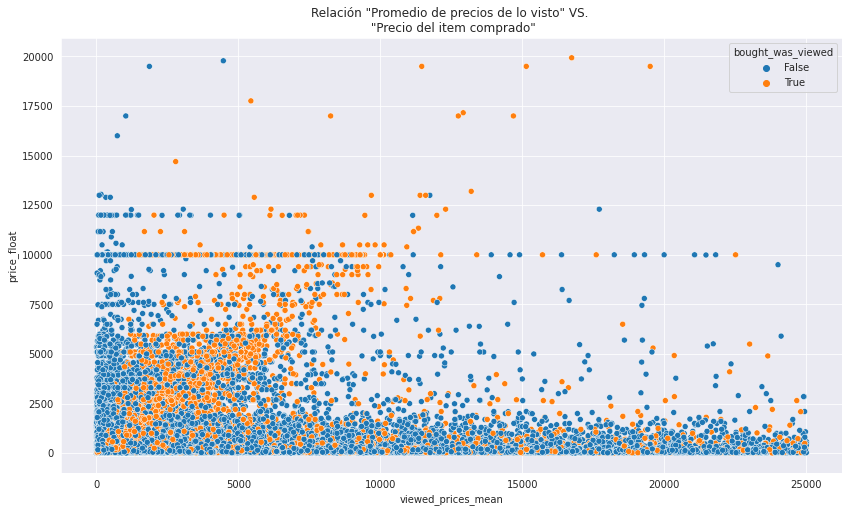

In [35]:
fig, ax = plt.subplots(1,figsize=(14,8))
sns.scatterplot(data=df_joined[(df_joined.price_float < 25000) & (df_joined.viewed_prices_mean < 25000)], x='viewed_prices_mean', y='price_float', hue='bought_was_viewed', ax=ax)
ax.set_title('Relación "Promedio de precios de lo visto" VS. \n "Precio del item comprado"')
# sns.lineplot(data=df_joined[(df_joined.price_float < 25000) & (df_joined.viewed_prices_mean < 25000)], x='viewed_prices_mean', y='price_float', hue='bought_was_viewed', ax=axes[1])

### Relación "cantidad de eventos (views+searches) del user" vs "Precio del item comprado"

Text(0.5, 1.0, 'Relación "Cantidad de eventos (views + searches)" VS. \n "Precio del item comprado"')

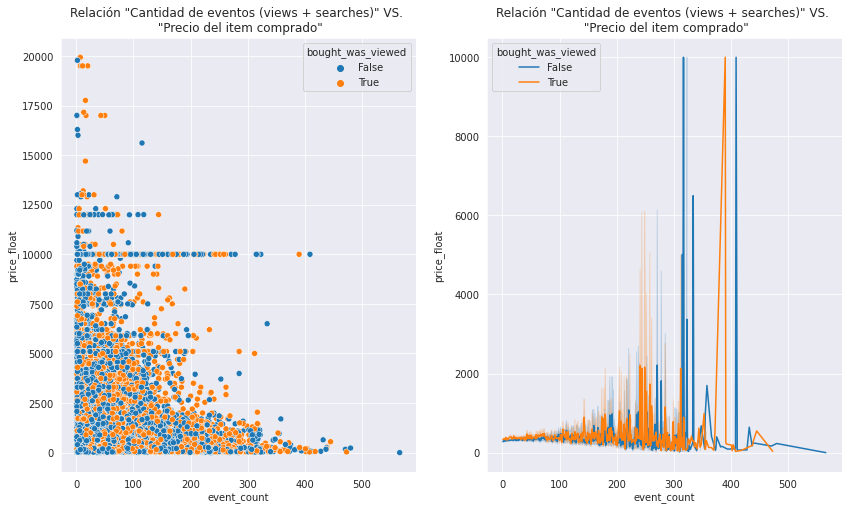

In [36]:
fig, axes = plt.subplots(1,2,figsize=(14,8))
sns.scatterplot(data=df_joined[(df_joined.price_float < 25000) ], x='event_count', y='price_float', hue='bought_was_viewed',ax=axes[0])
axes[0].set_title('Relación "Cantidad de eventos (views + searches)" VS. \n "Precio del item comprado"')
sns.lineplot(data=df_joined[(df_joined.price_float < 25000) ], x='event_count', y='price_float', hue='bought_was_viewed', ax=axes[1])
axes[1].set_title('Relación "Cantidad de eventos (views + searches)" VS. \n "Precio del item comprado"')

Se observa:


1.   Hay algún tipo de ruido en la columna "Price". Se ve el precio 10000 repetido más de la cuenta, gracias a los scatterplot.
2.   Hay una relación entre el precio de lo visto y el precio de lo finalmente comprado, para los casos de users que vieron lo que terminaron comprando (lo que era probable, siendo que la mayor parte de los users hacen muy pocas vistas totales, por lo que la mayoría vieron únicamente lo que terminaron comprando)
3. No parece haber una relación entre el promedio de precios y el item comprado para los users que NO miraron el item que terminan comprando
4. Mirando el scatterplot, pareciera haber una relación (decreciente) entre cantidad de eventos (views+searches) y el precio del item comprado... Pero esto no es real. Lo que ocurre es que al haber una mayor cantidad de casos con bajos eventos, el spread del precio es mayor (esto se confirma con el lineplot).
5. Se debe reanalizar el punto 3 tomando únicamente las vistas del domain de la compra para el promedio de precios. 



In [37]:

for col in itemdf.columns:
  print(col, len(itemdf[itemdf[col].isnull()]))

item_id 0
title 0
domain_id 851
product_id 1805749
price 339
category_id 0
condition 856


Muchos nulls en itemdf para el product_id. Muy pocos para las demás columnas.

##CANTIDAD DE PUNTOS DONDE SE VIO ITEMS EN MÁS DE UN PAIS: 44 / 413000

In [39]:
item_list = itemdf['item_id'].tolist()
domain_list = itemdf['domain_id'].tolist()
item_domain_dict = dict(zip(item_list, domain_list))

In [40]:
def count_countries(history):
  countries = []
  for hist in history:
    if hist['event_type'] == 'view':
      # country = itemdf[itemdf.item_id == hist['event_info']].domain_id.str[:3].values[0]
      # # print(type(country))
      country = item_domain_dict[hist['event_info']]
      if country:
        countries.append(country[:3])
  return len(set(countries))

df_joined['multiple_countries'] = df_joined.user_history.apply(count_countries) 
# df_joined['multiple_countries'] = df_joined.user_history.apply(lambda events: (len(set([itemdf[itemdf.item_id == int(float(history['event_info']))].domain_id.str[:3] for history in events if history['event_type'] == 'view'])) != 1)) 
df_joined.multiple_countries.value_counts()

1    386291
0     26828
2        44
Name: multiple_countries, dtype: int64

Por ende las poblaciones están afortunadamente muy separadas

##El domain de la compra estuvo entre los items vistos? 
Cierto para aprox el 50% de los casos (203857 sobre 413163)

In [41]:
df_joined['domain_was_searched'] = df_joined.apply(lambda row: row['domain_id'] in [item_domain_dict[history['event_info']] for history in row['user_history'] if history['event_type'] == 'view'], axis=1)
df_joined.domain_was_searched.value_counts()

False    209306
True     203857
Name: domain_was_searched, dtype: int64

Text(0.5, 1.0, 'Comparación abierta por vistas \n totales en el history')

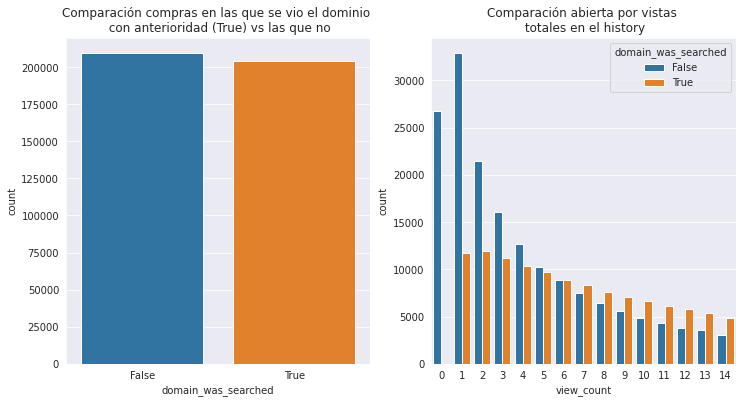

In [42]:
fig, axes = plt.subplots(1,2,figsize=(12,6))
sns.countplot(data=df_joined, x='domain_was_searched', ax=axes[0])
sns.countplot(data=df_joined[df_joined.view_count < 15], x='view_count', hue='domain_was_searched', ax=axes[1])
axes[0].set_title('Comparación compras en las que se vio el dominio \n con anterioridad (True) vs las que no')
axes[1].set_title('Comparación abierta por vistas \n totales en el history')

##Cuántas veces aparece el domain de la compra?

In [43]:
def contar_domain(row):
  count = 0
  if row.domain_was_searched == False:
    return 0
  else:
    for history in row['user_history']:
      if history['event_type'] == 'view':
        if item_domain_dict[history['event_info']] == row.domain_id:
          count += 1
    return count

df_joined['domain_views_times'] = df_joined.apply(contar_domain, axis=1)


Text(0.5, 1.0, 'Cuántas veces aparece el domain de la compra?')

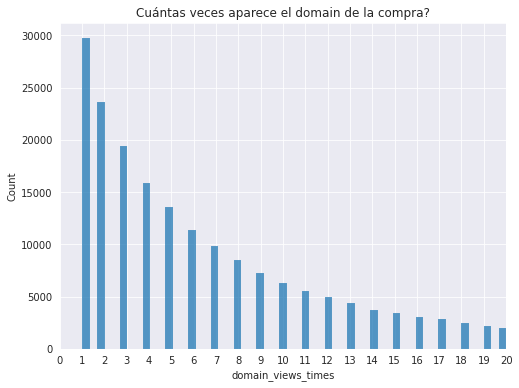

In [44]:
fig, ax = plt.subplots(figsize=(12,10))
sns.histplot(data=df_joined[df_joined.domain_was_searched == True]['domain_views_times'], ax=ax)
ax.set_xlim(0,20)
ax.set_xticks(list(range(21)))
ax.set_title('Cuántas veces aparece el domain de la compra?')

(0.0, 2000.0)

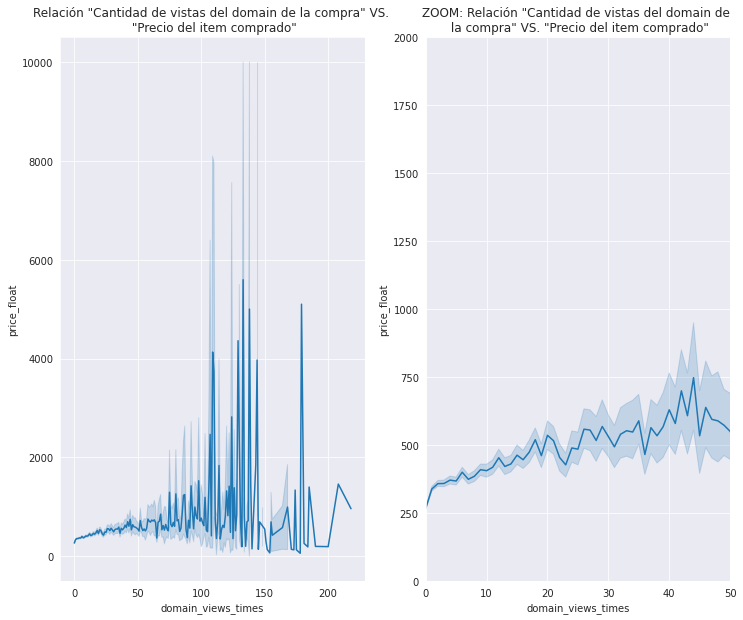

In [101]:
fig, axes = plt.subplots(1,2,figsize=(12,10))
sns.lineplot(data=df_joined[(df_joined.price_float < 25000) ], x='domain_views_times', y='price_float', ax=axes[0])
sns.lineplot(data=df_joined[(df_joined.price_float < 25000) ], x='domain_views_times', y='price_float', ax=axes[1])
axes[0].set_title('Relación "Cantidad de vistas del domain de la compra" VS. \n "Precio del item comprado"')
axes[1].set_title('ZOOM: Relación "Cantidad de vistas del domain de \n la compra" VS. "Precio del item comprado"')
axes[1].set_xlim(0,50)
axes[1].set_ylim(0,2000)

Pareciera haber una tendencia CRECIENTE (!) entre la cantidad de veces que un user mira el domain de la compra, y el precio del item que elige: A mayor análisis, mayor precio promedio.... O al revés: las cosas que son más caras requieren mayor análisis.

##Cuántos domains diferentes fueron vistos

In [46]:
df_joined['unique_domains_viewed'] = df_joined.apply(lambda row: len(set([item_domain_dict[history['event_info']] for history in row['user_history'] if history['event_type'] == 'view'])), axis=1)


Text(0.5, 1.0, 'Cuántos domains diferentes fueron vistos')

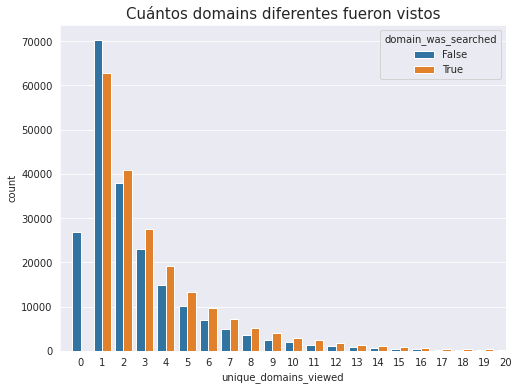

In [98]:
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(data=df_joined, x='unique_domains_viewed',
              ax=ax, hue='domain_was_searched')

# ax.set_xticks(list(range(30)))
ax.set_xlim(-1,20)
ax.set_title('Cuántos domains diferentes fueron vistos', fontdict={'fontsize':15})

##Relación vistas del domain de la compra / vistas totales:

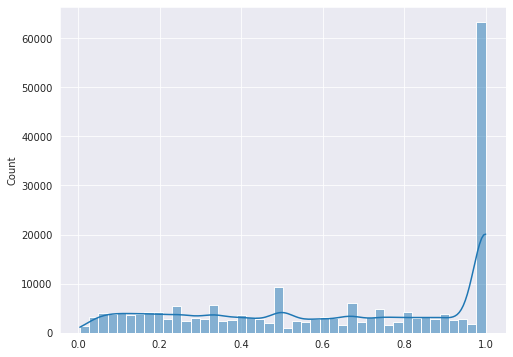

In [48]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(data=df_joined[df_joined.domain_was_searched == True]['domain_views_times'] / df_joined[df_joined.domain_was_searched == True]['view_count'], 
             ax=ax, kde=True)
# ax.set_xlim(0,20)

##Sirve categorizar a los compradores según horas en las que hacen searches y views?

##Sirve categorizar a los compradores según la cantidad de views o searches que hacen?

In [49]:
# print(df.columns)
# for col in df.columns:
#   print(col,'-------asd', print(df[col].duplicated().value_counts()))
#   print('\n \n \n')

In [50]:
# sns.pairplot(df_joined)

## Posibilidades: Eliminar a todos los que no vieron el dominio comprado, y entrenar unicamente con el otro 50%

## Entrenar con los dos grupos de datos por separado. Analizar si entre el 50% que no busco el dominio de la compra, existen patrones en comun: buscan en random? algun otro patron que nos permita identificarlos?

## Chequear % de vistas del domain de la compra, separado por domain
## Interpretar mediante NLP las searches a un domain (o a un product si se da)
## Agregar una columna con el domain predicho por las searches, o incluso una matriz con domains. Re-analizar distribucion de gente que vio ALGO sobre su producto de compra, teniendo en cuenta las searches (quizás no entraron a  ninguna view, pero sí estuvieron buscando sobre el producto)

# Nueva sección